## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


In this homework, we will use the Bank Marketing dataset. Download it from [here](https://archive.ics.uci.edu/static/public/222/bank+marketing.zip).

You can do it with `wget`:

In [60]:
# !wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
# !unzip bank+marketing.zip 
# !unzip bank.zip

We need `bank-full.csv`.

In this dataset the target variable is `y` variable - has the client subscribed a term deposit or not. 


### Dataset preparation

For the rest of the homework, you'll need to use only these columns:

* `'age'`,
* `'job'`,
* `'marital'`,
* `'education'`,
* `'balance'`,
* `'housing'`,
* `'contact'`,
* `'day'`,
* `'month'`,
* `'duration'`,
* `'campaign'`,
* `'pdays'`,
* `'previous'`,
* `'poutcome'`,
* `'y'`



Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`



In [61]:
import pandas as pd
import numpy as np

In [62]:
df = pd.read_csv('bank-full.csv', delimiter=';')

In [63]:
selected_columns = ['age', 'job', 'marital', 'education', 'balance', 'housing', 
                    'contact', 'day', 'month', 'duration', 'campaign', 
                    'pdays', 'previous', 'poutcome', 'y']

In [64]:
df['y'] = df['y'].map({'yes': 1, 'no': 0})

In [65]:
df = df[selected_columns]
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,0


In [66]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
%matplotlib inline

In [67]:
def train_val_test_split(df, target, train_size, val_size, test_size, random_state):
    
    df_full_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    val_portion = val_size / (train_size + val_size)
    df_train, df_val = train_test_split(df_full_train, test_size=val_portion, random_state=random_state)

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = df_train[target].values
    y_val = df_val[target].values
    y_test = df_test[target].values

    del df_train[target]
    del df_val[target]
    del df_test[target]

    return df_full_train, df_train, df_test, df_val, y_train, y_val, y_test

In [68]:
df_full_train, df_train, df_test, df_val, y_train, y_val, y_test = \
    train_val_test_split(df=df, target='y', train_size=0.6, val_size=0.2, test_size=0.2, random_state=1)

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `y` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `balance`
- `day`
- `duration`
- `previous`

In [69]:
numerical_vars = ['balance', 'day', 'duration', 'previous']

best_auc = -1
best_variable = None


for var in numerical_vars:
    auc = roc_auc_score(y_train, df_train[var])
    
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[var])
    print(var, "AUC", auc)
    
    if auc > best_auc:
        best_auc = auc
        best_variable = var

print("Variable with the highest AUC:", best_variable)

balance AUC 0.5888313805382317
day AUC 0.525957882383908
duration AUC 0.8147002759670778
previous AUC 0.5985653242764153
Variable with the highest AUC: duration


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.69
- 0.79
- 0.89
- 0.99

In [70]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [71]:
dv, model = train(df_train=df_train, y_train=y_train, C=1.0)
y_pred = predict(df=df_val, dv=dv, model=model)
print(f'AUC on the validaiton dataset', round(roc_auc_score(y_val,y_pred), 3))

AUC on the validaiton dataset 0.9


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.265
* 0.465
* 0.665
* 0.865

In [72]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred > t)
    predict_negative = (y_pred <= t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [73]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

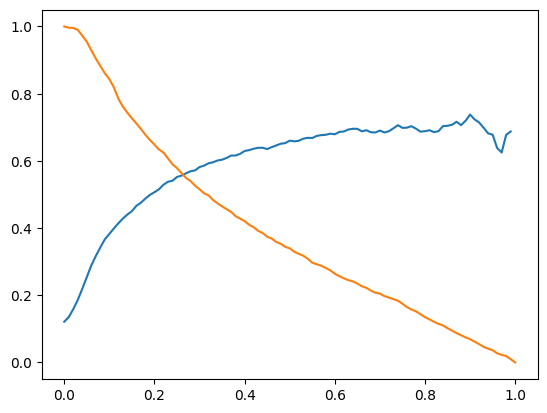

In [74]:
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')

In [75]:
df_scores['diff'] = abs(df_scores.precision - df_scores.recall)
df_scores[df_scores['diff'] == df_scores['diff'].min()]

,threshold,tp,fp,fn,tn,tpr,fpr,precision,recall,diff
26,0.26,619,494,479,7450,0.563752,0.062185,0.556155,0.563752,0.007598


### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- 0.22
- 0.42
- 0.62


In [76]:
df_scores['f1_score'] = 2 * df_scores['precision'] * df_scores['recall'] / \
                        (df_scores['precision'] + df_scores['recall'])

In [77]:
max_f1 = 0
max_threshold = 0
thresholds = np.linspace(0, 1, 101)
for threshold in thresholds:
    # print("Threshold=", threshold, "F1 Score",df_scores['f1_score'][df_scores.threshold == threshold].values)
    f1 = df_scores['f1_score'][df_scores.threshold == threshold].values
    if f1 > max_f1:
        max_f1 = f1
        max_threshold = threshold
print("Max F1 Score:", max_f1)
print("Threshold for Max F1 Score:", max_threshold)

Max F1 Score: [0.57286013]
Threshold for Max F1 Score: 0.22


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.26

In [78]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [79]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    del df_train['y']
    del df_val['y']

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('C=%s Mean AUC Score %.3f +- STD %.4f' % (1.0, np.mean(scores), np.std(scores)))

C=1.0 Mean AUC Score 0.906 +- STD 0.0057


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.


In [80]:
from tqdm.auto import tqdm

In [81]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [82]:
for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values
        
        del df_train['y']
        del df_val['y']

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s Mean AUC Score %.3f +- STD %.3f' % (C, np.mean(scores), np.std(scores)))

 33%|███▎      | 1/3 [00:02<00:05,  3.00s/it]

C=1e-06 Mean AUC Score 0.701 +- STD 0.009


 67%|██████▋   | 2/3 [00:06<00:03,  3.21s/it]

C=0.001 Mean AUC Score 0.861 +- STD 0.007


100%|██████████| 3/3 [00:10<00:00,  3.36s/it]

C=1 Mean AUC Score 0.906 +- STD 0.006
